In [1213]:
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Descriptors import MolWt
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import pandas as pd
import numpy as np
import random
random.seed(42)

from tqdm.auto import tqdm
tqdm.pandas()

In [729]:
def assign_activity(df_row):
    try:
        if df_row['activity_comment'].isna() and df_row['standard_relation'] in ["<", "<=", "=", "~"] and df_row['logged_values'] >= 5.0:
            return 'active_new'
    except Exception as e:
        return df_row['activity_comment']
    try:
        if df_row['activity_comment'].isna() and df_row['standard_relation'] in [">", ">=", "=", "~"] and df_row['logged_values'] <= 4.5:
            return 'inactive_new'
    except Exception as e:
        return df_row['activity_comment']        
    try:
        if df_row['activity_comment'].isna() and df_row['logged_values'] < 5.5 and df_row['logged_values'] > 4.5:
            return 'inconclusive_new'
    except Exception as e:
        return df_row['activity_comment']

In [4]:
def map_activity_to_label(x):
    if x in ['Not Active', 'inactive']:
        return 0.
    elif x in ['active_new', 'Active', 'active']:
        return 1.
    else:
        return float('nan') 

## Load data that was previously queried from ChEMBL

In [730]:
df2 = pd.read_csv('../../../Downloads/chembl_20_mysql/all_bacterial.csv')

# Following the procedure described by Mayr et al., 2018
df2['logged_values'] = - np.log(df2.standard_value * 10 ** (-9))

/Users/kamen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The warning is because of the NaNs in the standard values.

In [731]:
pref_name_to_chembl_id = df2[['pref_name', 'chembl_id']].drop_duplicates().set_index('pref_name').to_dict()['chembl_id']

In [734]:
dict(df2.chembl_id.value_counts().head(30))

{'CHEMBL2026': 62081,
 'CHEMBL1293248': 24810,
 'CHEMBL2146309': 8528,
 'CHEMBL4372': 7180,
 'CHEMBL1293228': 5799,
 'CHEMBL1741192': 4202,
 'CHEMBL1741171': 2209,
 'CHEMBL1293264': 1188,
 'CHEMBL1795096': 968,
 'CHEMBL1293246': 810,
 'CHEMBL5441': 521,
 'CHEMBL2095183': 517,
 'CHEMBL2146295': 502,
 'CHEMBL6137': 501,
 'CHEMBL5192': 498,
 'CHEMBL1293244': 441,
 'CHEMBL2902': 427,
 'CHEMBL1293285': 422,
 'CHEMBL3423': 402,
 'CHEMBL5766': 370,
 'CHEMBL2725': 369,
 'CHEMBL1849': 333,
 'CHEMBL5328': 330,
 'CHEMBL5457': 302,
 'CHEMBL2146299': 298,
 'CHEMBL2065': 264,
 'CHEMBL2802': 253,
 'CHEMBL3564': 252,
 'CHEMBL2361': 227,
 'CHEMBL2095232': 225}

In [733]:
top20_organisms = dict(df2.organism.value_counts().head(30))

In [735]:
df3 = df2

In [736]:
df3['activity_comment'] = df2.apply(lambda x: assign_activity(x), axis=1)

In [737]:
df2['activity_comment'] = df3['activity_comment']
del df3

In [738]:
df2.activity_comment.value_counts()

Inconclusive    71270
Active          17214
Not Active      14031
active          13446
inactive         7209
inconclusive      139
Name: activity_comment, dtype: int64

In [739]:
df2 = df2.drop(index=df2.loc[(df2['activity_comment'].isna())].index)

In [740]:
df2

,assay_id,confidence_score,activity_comment,standard_units,standard_value,standard_type,standard_relation,pref_name,chembl_id,organism,canonical_smiles,logged_values
93,647757,9,Active,NaN,NaN,Inhibition,NaN,Dihydrofolate reductase,CHEMBL1809,Escherichia coli K-12,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,NaN
94,647767,9,Active,NaN,NaN,Inhibition,NaN,Dihydrofolate reductase,CHEMBL1809,Escherichia coli K-12,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,NaN
95,647927,9,Active,NaN,NaN,Inhibition,NaN,Dihydrofolate reductase,CHEMBL1809,Escherichia coli K-12,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,NaN
96,650704,9,Active,NaN,NaN,Inhibition,NaN,Dihydrofolate reductase,CHEMBL1809,Escherichia coli K-12,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,NaN
97,650705,9,Active,NaN,NaN,Inhibition,NaN,Dihydrofolate reductase,CHEMBL1809,Escherichia coli K-12,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
139146,1353640,7,Active,NaN,NaN,Inhibition,NaN,Antrax lethal toxin,CHEMBL3301396,Bacillus anthracis,Cc1cccc(C)c1NC(=O)N\N=C\c2ccc(cc2)N=[N+]=[N-],NaN
139147,1353640,7,Active,NaN,NaN,Inhibition,NaN,Antrax lethal toxin,CHEMBL3301396,Bacillus anthracis,Cc1cccc(C)c1NC(=O)N\N=C\c2c(F)c(F)c(N=[N+]=[N-...,NaN
139148,1353641,7,Active,NaN,NaN,Inhibition,NaN,Antrax lethal toxin,CHEMBL3301396,Bacillus anthracis,Cc1cccc(C)c1NC(=O)N\N=C\c2ccc(cc2)N=[N+]=[N-],NaN
139149,1353641,7,Active,NaN,NaN,Inhibition,NaN,Antrax lethal toxin,CHEMBL3301396,Bacillus anthracis,Cc1cccc(C)c1NC(=O)N\N=C\c2c(F)c(F)c(N=[N+]=[N-...,NaN


## Filter molecules with contradicting activities

In [741]:
questionable = {}
visited = {}
for i, row in df2.iterrows():
    if (row[-4],row[-2]) not in visited.keys():
        visited[(row[-4],row[-2])] = row[2]
    elif visited[(row[-4],row[-2])] == row[2]:
        continue
    else:
        if (row[-4],row[-2]) not in questionable.keys():
            questionable[(row[-4],row[-2])] = [visited[(row[-4],row[-2])],row[2]]
        elif (row[-4],row[-2]) in questionable.keys():
            questionable[(row[-4],row[-2])].append(row[2])
    

## Assign labels

In [742]:
for chembl_id,smi in questionable.keys():
    mask = (df2['chembl_id']==chembl_id) & (df2['canonical_smiles'] == smi)
    df2 = df2.loc[~mask]

In [743]:
df2['label'] = df2['activity_comment'].apply(map_activity_to_label)

In [744]:
df2 = df2.loc[~df2['label'].isna()]

## Keep only examples with at least 40 active examples. We can easily enrich the data in decoys.

In [1207]:
acts = df2.loc[df2['label']==1].groupby('chembl_id').count().reset_index()
acts = acts[(acts['label'] >= 40) & (acts['label'] <= 2000)]

In [1208]:
inacts = df2.loc[df2['label']==0].groupby('chembl_id').count().reset_index()
inacts = inacts[(inacts['label'] >= 20) ]

In [749]:
pd.options.display.max_rows = 100

In [1209]:
acts_and_inacts2 = pd.merge(acts, inacts[['chembl_id', 'label']], on='chembl_id')

In [1210]:
acts_and_inacts2

,chembl_id,assay_id,confidence_score,activity_comment,standard_units,standard_value,standard_type,standard_relation,pref_name,organism,canonical_smiles,logged_values,label_x,mol_wt,label_y
0,CHEMBL1287620,149,149,149,149,149,149,149,149,149,149,149,149,149,25
1,CHEMBL1293246,263,263,263,263,263,263,262,263,263,263,263,263,263,395
2,CHEMBL1293264,49,49,49,49,49,49,49,49,49,49,49,49,49,1116
3,CHEMBL1741171,1802,1802,1802,1802,1802,1802,1802,1802,1802,1802,1802,1802,1802,163
4,CHEMBL2026,155,155,155,155,155,155,155,155,155,155,155,155,155,8816
5,CHEMBL2095183,74,74,74,74,74,74,74,74,74,74,74,74,74,44
6,CHEMBL4372,477,477,477,476,476,477,467,477,477,477,476,477,477,144
7,CHEMBL5114,40,40,40,0,0,40,0,40,40,40,0,40,40,24
8,CHEMBL5766,229,229,229,229,229,229,0,229,229,229,229,229,229,141


In [756]:
naming = df2[['chembl_id', 'pref_name', 'organism']].drop_duplicates()

In [411]:
def add_pref_name_and_organism(df_row):
    return df_row['pref_name'] + ", " + df_row['organism']

In [757]:
naming['full_name'] = naming.apply(add_pref_name_and_organism, axis=1)

In [758]:
chembl_id_to_full_name = {k:v for k,v in naming[['chembl_id','full_name']].values}

In [1211]:
idx_to_target_name = {}
for i,t in enumerate(acts_and_inacts2.chembl_id):
    idx_to_target_name[i] = t + '\n' + chembl_id_to_full_name[t]

In [1212]:
idx_to_target_name

{0: 'CHEMBL1287620\nFructose-bisphosphate aldolase, Mycobacterium tuberculosis',
 1: 'CHEMBL1293246\nBeta Lactamase, Pseudomonas aeruginosa',
 2: 'CHEMBL1293264\nBeta-galactosidase, Escherichia coli',
 3: 'CHEMBL1741171\nProtein RecA, Mycobacterium tuberculosis',
 4: 'CHEMBL2026\nBeta-lactamase AmpC, Escherichia coli K-12',
 5: 'CHEMBL2095183\nShiga toxin, Escherichia coli O157:H7',
 6: 'CHEMBL4372\nAnthrax lethal factor, Bacillus anthracis',
 7: 'CHEMBL5114\nQuinolone resistance protein norA, Staphylococcus aureus',
 8: 'CHEMBL5766\nAcyl-CoA synthase, Mycobacterium tuberculosis'}

### To be used in the other notebooks

In [761]:
with open('idx_to_target_name_no_dups.pcl','wb') as f:
    pickle.dump(idx_to_target_name, f)

In [803]:
chembl_id_targets = acts_and_inacts2.chembl_id

In [764]:
df2['mol_wt'] = df2['canonical_smiles'].apply(lambda x: MolWt(Chem.MolFromSmiles(x)))

In [804]:
df_correct_targets = df2.loc[df2.chembl_id.isin(chembl_id_targets)].reset_index(drop=True)

In [805]:
quantiles_negative = [df_correct_targets.loc[df_correct_targets['label']==0].mol_wt.quantile(q=q) for q in [0.1, 0.9]]

In [806]:
quants = [[quantiles_negative[0], 0.6, 0.16], [quantiles_negative[1], 0.8, 0.26]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

### Consider the distribution of molecular weights in the tested dataset, in order to enrich in decoys with similar weights.

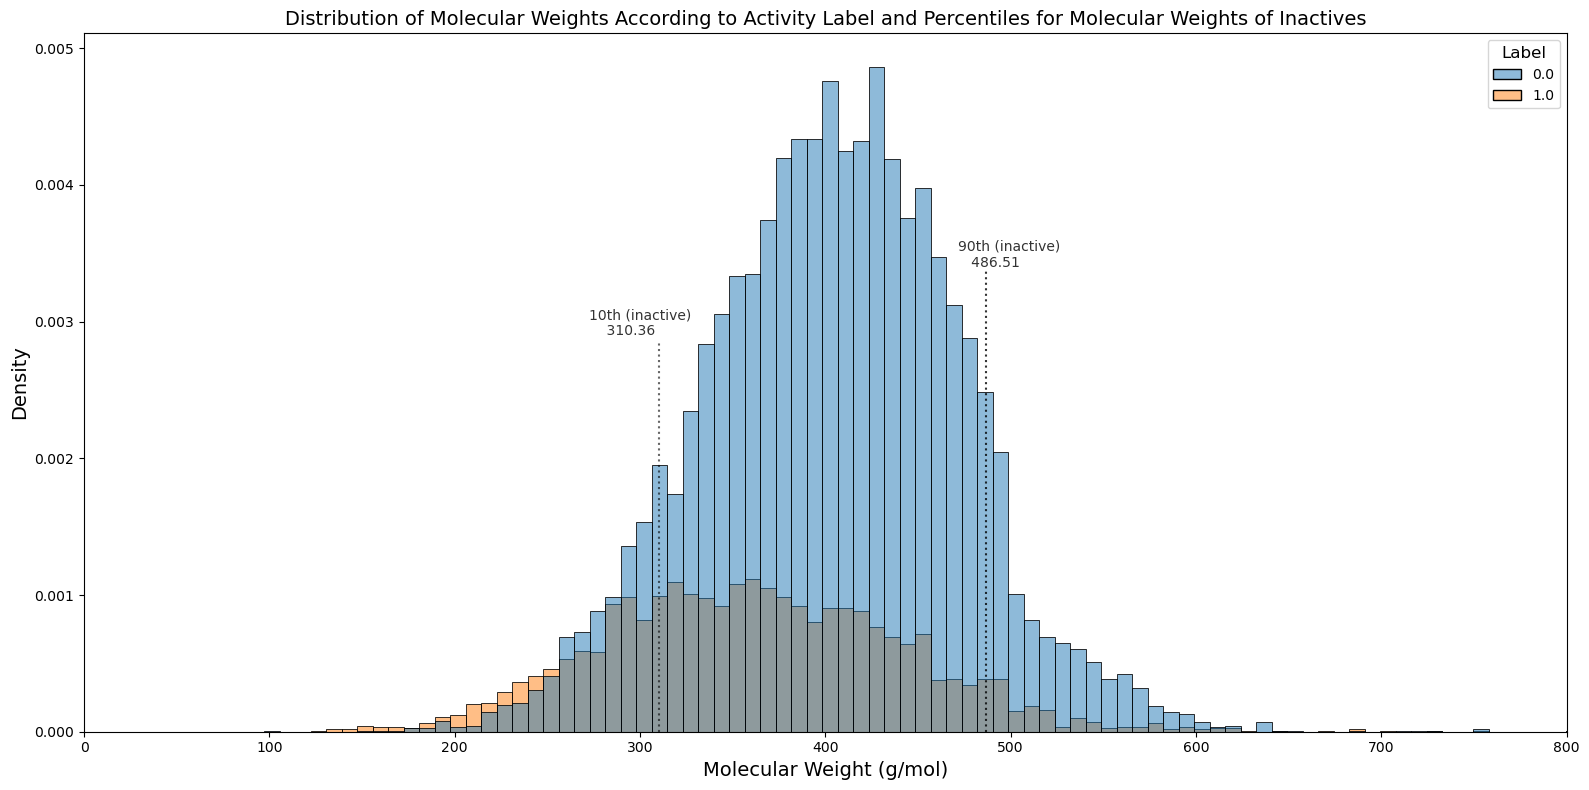

In [1097]:
fig, ax = plt.subplots(figsize = (16,8))
g = sn.histplot(data=df_correct_targets, x='mol_wt', stat='density', hue='label')
g.legend_.set_title('Label', prop={'size':12,})
plt.xlim((0,800))
quants = [[quantiles_negative[0], 0.6, 0.56], [quantiles_negative[1], 0.8, 0.66]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color='black')
ax.text(quants[0][0]-38, 0.0029, f"10th (inactive) \n    {round(quants[0][0], 2)}", size = 10, alpha = 0.8)
ax.text(quants[1][0]-15, 0.0034, f"90th (inactive)\n   {round(quants[1][0], 2)}", size = 10, alpha = 0.8)
plt.xlabel('Molecular Weight (g/mol)', fontsize=14)
plt.ylabel('Density', fontsize=14,)
plt.title('Distribution of Molecular Weights According to Activity Label and Percentiles for Molecular Weights of Inactives', fontsize=14)
plt.tight_layout()
plt.savefig('pictures_2/molecular_weights_for_enrichment.png')

In [505]:
df2['morgan_fp'] = df2['canonical_smiles'].apply(lambda smi: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=2, useChirality=True))

In [808]:
df_correct_targets['morgan_fp'] = df_correct_targets['canonical_smiles'].progress_apply(lambda smi: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=2, useChirality=True))

  0%|          | 0/14434 [00:00<?, ?it/s]

In [1104]:
np.unique(df_correct_targets.chembl_id)

array(['CHEMBL1287620', 'CHEMBL1293246', 'CHEMBL1293260', 'CHEMBL1293264',
       'CHEMBL1741171', 'CHEMBL2026', 'CHEMBL2095183', 'CHEMBL4372',
       'CHEMBL5114', 'CHEMBL5344', 'CHEMBL5766'], dtype=object)

In [1106]:
chembl_id_targets = ['CHEMBL1287620', 'CHEMBL1293246', 'CHEMBL1293264', 'CHEMBL1741171', 'CHEMBL2026', 'CHEMBL2095183', 'CHEMBL4372', 'CHEMBL5114', 'CHEMBL5766']

In [1137]:
intra_pos_simis_per_target = []
for t in chembl_id_targets:
    simi = []
    for i, smi1 in tqdm(enumerate(df_correct_targets.loc[(df_correct_targets['chembl_id'] == t) & (df_correct_targets['label'] == 1.)]['morgan_fp'].values[:-1])):
        for j, smi2 in enumerate(df_correct_targets.loc[(df_correct_targets['chembl_id'] == t) & (df_correct_targets['label'] == 1.)]['morgan_fp'].values[i+1:]):
            simi.append(DataStructs.TanimotoSimilarity(smi1, smi2))
    intra_pos_simis_per_target.append(simi)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [1144]:
for t in chembl_id_targets:
    print(len(df_correct_targets.loc[(df_correct_targets['chembl_id'] == t) & (df_correct_targets['label'] == 0.)]['morgan_fp'].values))

25
363
958
159
8688
42
119
12
140


In [1145]:
intra_neg_pos_simis_per_target = []
for t in chembl_id_targets:
    simi = []
    for i, smi1 in tqdm(enumerate(df_correct_targets.loc[(df_correct_targets['chembl_id'] == t) & (df_correct_targets['label'] == 0.)]['morgan_fp'].values)):
        for j, smi2 in enumerate(df_correct_targets.loc[(df_correct_targets['chembl_id'] == t) & (df_correct_targets['label'] == 1.)]['morgan_fp'].values):
            simi.append(DataStructs.TanimotoSimilarity(smi1, smi2))
    intra_neg_pos_simis_per_target.append(simi)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [1107]:
intra_pos_simis = []
for i, smi1 in tqdm(enumerate(df_correct_targets.loc[(df_correct_targets['chembl_id'] == t) & (df_correct_targets['label'] == 1.)]['morgan_fp'].values)):
    for j, smi2 in enumerate(df_correct_targets.loc[(df_correct_targets['chembl_id'] == t) & (df_correct_targets['label'] == 1.)]['morgan_fp'].values[i:]):
        simi = DataStructs.TanimotoSimilarity(smi1, smi2)
        #intra_pos_simis.append(simi)

0it [00:00, ?it/s]

In [1099]:
intra_pos_simis = np.array(intra_pos_simis)

In [1100]:
quantiles_negative = [np.quantile(intra_pos_simis, q=q) for q in [0.05, 0.95]]

In [1101]:
intra_pos_simis.shape

(5846490,)

### Check for significant differences in similarity of actives and decoys to determine a similarity threshold, from below which to sample putative decoys from the human dataset.

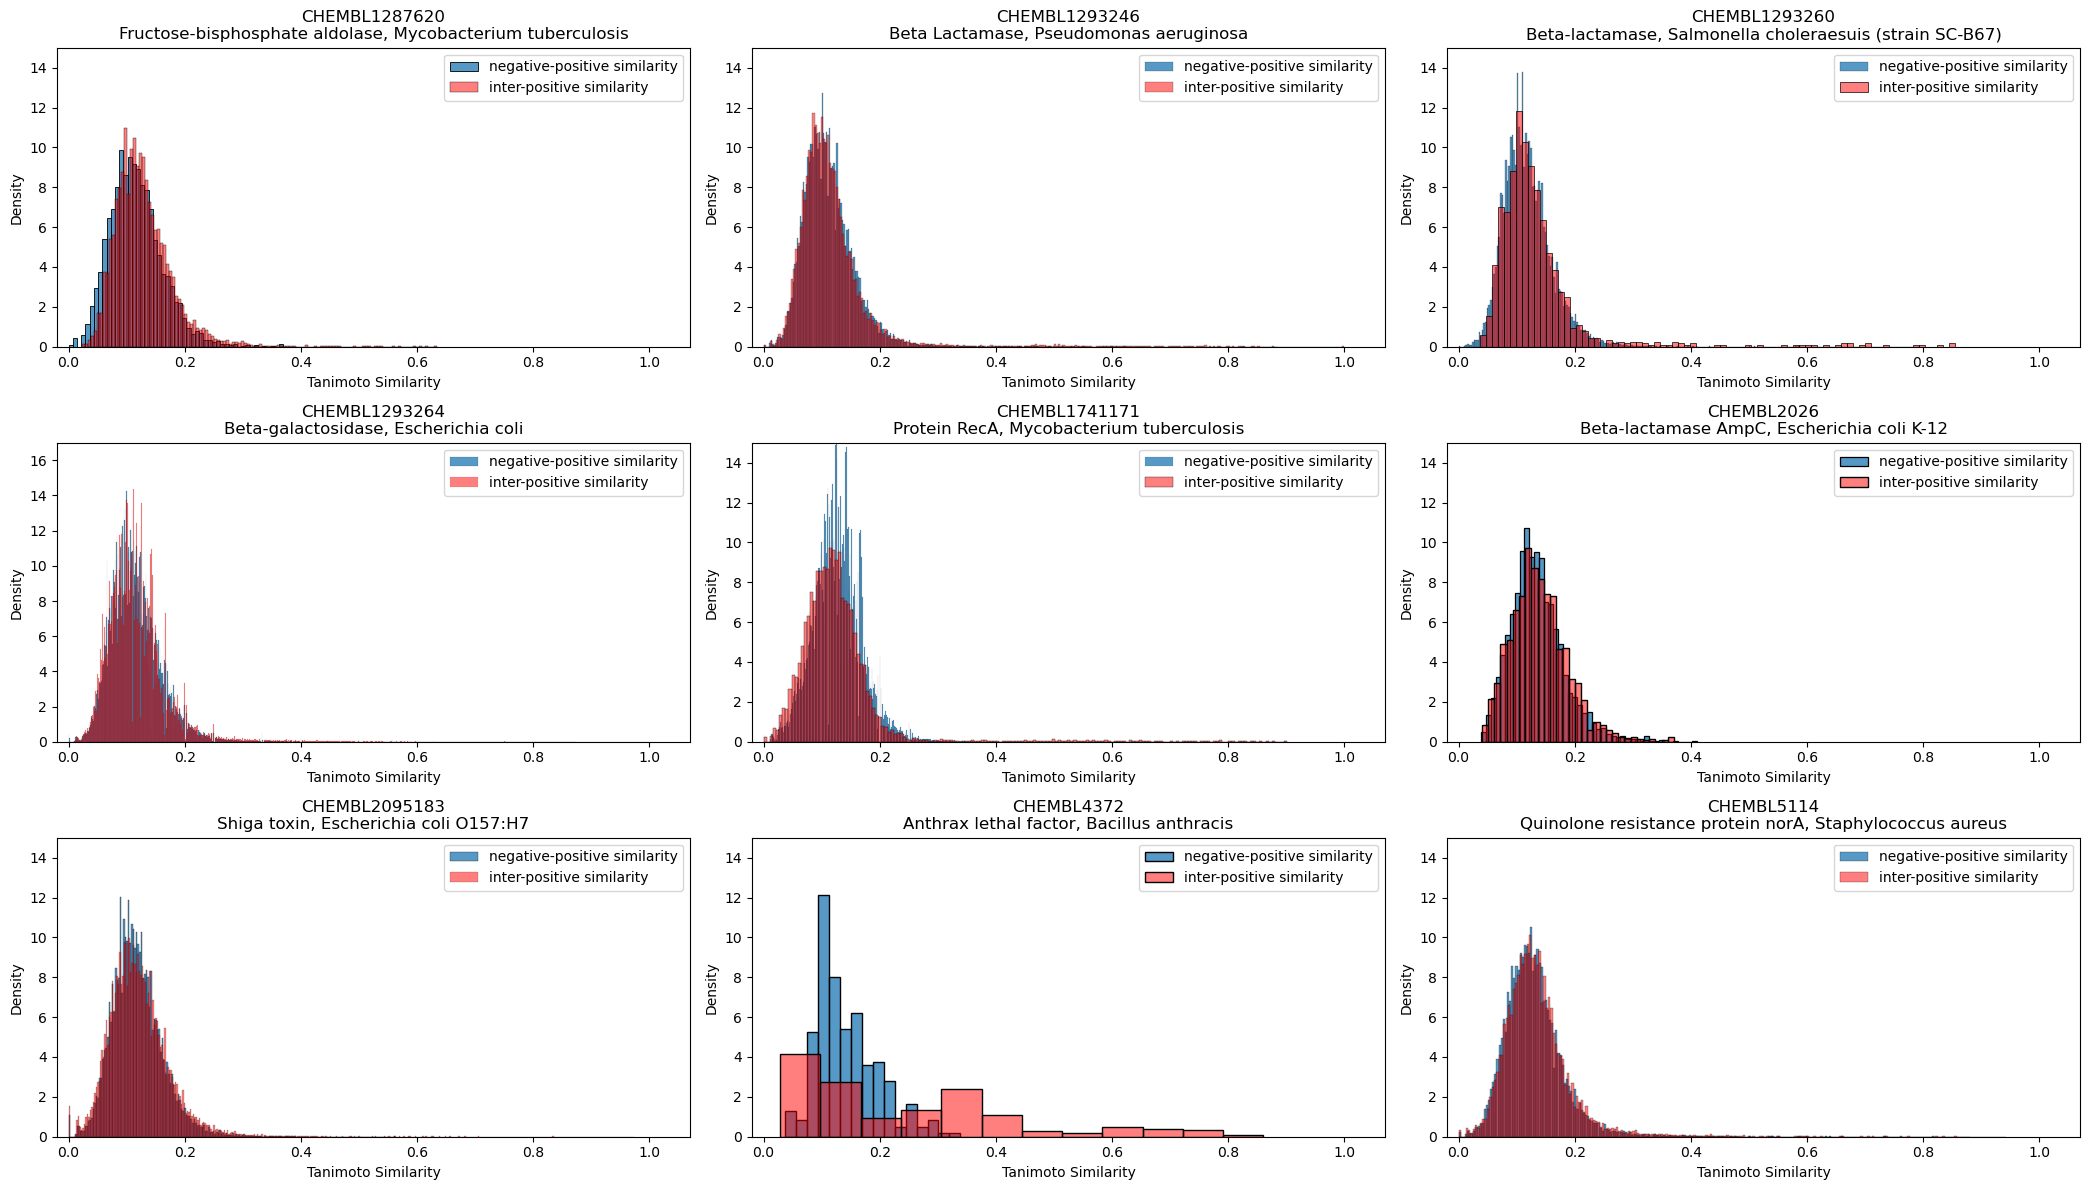

In [1156]:
fig, axs = plt.subplots(nrows=3, ncols=3,figsize = (21,12))
y1s = [10.5, 12.5, 12.5, 12.5, 11.5, 11, 11.5, 8., 11.]
y2s = y1s
for head, ax, y1, y2 in zip(range(9), axs.ravel(), y1s, y2s):
    ax.set_ylim((0,15))
    ym = y1/15
    if head==3:
        ax.set_ylim((0,17))
        y1=14
        y2=14
        ym = y1/17
    sn.histplot(x=intra_neg_pos_simis_per_target[head], stat='density', ax=ax,label='negative-positive similarity')
    sn.histplot(x=intra_pos_simis_per_target[head], stat='density', ax=ax, color='red', alpha=0.5, label='inter-positive similarity')
    ax.set_xlabel('Tanimoto Similarity')
    ax.legend()
    ax.set_xlim((-.02, 1.07))
    
    ax.set_title(idx_to_target_name[head])
    plt.tight_layout()
plt.savefig('pictures_2/similarity_of_negatives_to_positives_overlapped.png')

Text(0.5, 1.0, 'Tanimoto Similarity (ECFP4) of all active compound pairs')

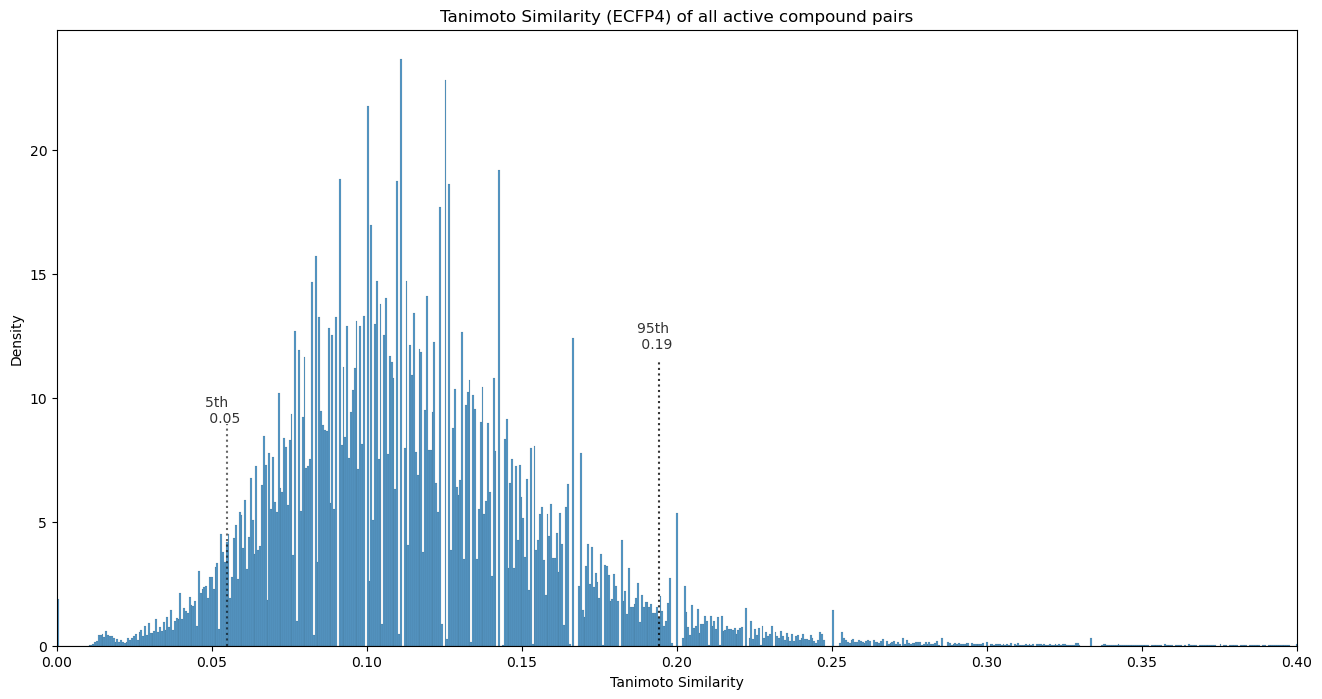

In [1103]:
fig, ax1 = plt.subplots(figsize = (16,8))
sn.histplot(x=intra_pos_simis, stat='density')
quants = [[quantiles_negative[0], 0.6, 0.36], [quantiles_negative[1], 0.8, 0.46]]
plt.xlim((0,1.1))
ax1.text(quants[0][0]-0.007, 9, f"5th \n {round(quants[0][0], 2)}", size = 10, alpha = 0.8)
ax1.text(quants[1][0]-0.007, 12, f"95th \n {round(quants[1][0], 2)}", size = 10, alpha = 0.8)
for i in quants:
    ax1.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color='black')
plt.xlabel('Tanimoto Similarity')
plt.xlim((0, 0.4))
plt.title('Tanimoto Similarity (ECFP4) of all active compound pairs')

### Load dataset of compounds test against human targets for putative inactives

In [582]:
df_human = pd.read_csv('../human/df_human_smiles_examples.csv')

In [585]:
df_human = df_human.loc[(df_human['mol_wt'] >= 305) & (df_human['mol_wt'] <= 485)]

In [591]:
df_human['morgan_fp'] = df_human['canonical_smiles'].progress_map(lambda smi: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=2, useChirality=True))

  0%|          | 0/705086 [00:00<?, ?it/s]

/var/folders/xm/ht_73jb97b5gk0nqhsyggc640000gn/T/ipykernel_12114/904296325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_human['morgan_fp'] = df_human['canonical_smiles'].progress_map(lambda smi: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=2, useChirality=True))


In [881]:
df_human = df_human.drop_duplicates('canonical_smiles').reset_index(drop=True)

In [883]:
df_human.sample(frac=1).reset_index(drop=True)

,canonical_smiles,label,mol_wt,morgan_fp
0,[O-][N+](=O)c1ccc(NC(=O)COC(=O)C2CN(Cc3ccccc3)...,0.0,476.283,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CN(c1ccccc1)S(=O)(=O)c2ccc(NC(=O)c3nc(ncc3Cl)S...,1.0,480.955,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Cn1c(CNC(=O)c2occc2)nnc1SCC(=O)c3ccccc3,0.0,356.407,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,COc1ccc(cc1)C2=NCC(CSc3nccc(O)n3)S2,1.0,333.438,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Cc1ccc2C(=CC(=O)Oc2c1C)CN3CCC(CC3)C(=O)N,0.0,314.385,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...
240603,COCCCN1C(=O)\C(=C\c2cc(OC)c(cc2OC)N3CCCC3)\S/C...,1.0,481.618,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
240604,NC(=O)c1ccc(cc1)c2nnc(Nc3ccc(cc3)S(=O)(=O)N)c4...,0.0,419.466,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
240605,Oc1ccccc1\C=N\C2=NN(CC2)c3cccc(c3)C(F)(F)F,1.0,333.313,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
240606,COc1ccccc1NS(=O)(=O)c2cccc(c2)C(=O)N\N=C\c3oc(...,0.0,413.455,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [1214]:
len(chembl_id_targets)

9

In [830]:
df_correct_targets = df_correct_targets.drop_duplicates(['activity_comment','chembl_id', 'canonical_smiles'])

In [904]:
id_to_chembl_id = dict(chembl_id_targets)

In [944]:
def get_clean_canonical_smiles(row):
    smiles = row['canonical_smiles']
    try:
        mol = Chem.MolFromSmiles(smiles)
        clean_mol = rdMolStandardize.Cleanup(mol) 

        parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

        uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
        uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
        te = rdMolStandardize.TautomerEnumerator() 
        taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
        bv = AllChem.GetMorganFingerprintAsBitVect(taut_uncharged_parent_clean_mol, radius=2, useChirality=True)
        #pd.Series([e,f,g], index=['a', 'b', 'c'])
        return pd.Series([Chem.CanonSmiles(Chem.MolToSmiles(taut_uncharged_parent_clean_mol)), bv], index=['canonical_smiles', 'morgan_fp']) #np.array([Chem.CanonSmiles(Chem.MolToSmiles(taut_uncharged_parent_clean_mol)), bv])
    except Exception as e:
        print(repr(e))
        return pd.Series([np.nan, np.nan], index=['canonical_smiles', 'morgan_fp'])

In [1031]:
%%capture _
res_human = df_human.progress_apply(get_clean_canonical_smiles, axis=1)

In [948]:
%%capture test
res1 = df_correct_targets.progress_apply(get_clean_canonical_smiles, axis=1)

In [1034]:
res_human = res_human.drop_duplicates('canonical_smiles')

In [1041]:
res_human = res_human.dropna()

In [1042]:
res_human = res_human.reset_index(drop=True)

In [952]:
df_correct_targets['morgan_fp'] = res1.values[:,1]

/var/folders/xm/ht_73jb97b5gk0nqhsyggc640000gn/T/ipykernel_12114/1842186572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct_targets['morgan_fp'] = res1.values[:,1]


In [1001]:
df_correct_targets = df_correct_targets.drop_duplicates('canonical_smiles').reset_index(drop=True)

In [969]:
df_correct_targets = df_correct_targets.loc[df_correct_targets['morgan_fp'].dropna().index].reset_index(drop=True)

In [1043]:
putative_inactives = []
putative_inactives_smi = []
positive_fps = []
negative_fps = []
positive_smiles = []
negative_smiles = []

for t in chembl_id_targets:
    curr = acts_and_inacts2.loc[acts_and_inacts2['chembl_id']==t]
    positives = curr['label_x'].values
    negatives = curr['label_y'].values
    negs = df_correct_targets.loc[(df_correct_targets['chembl_id'] == t) & (df_correct_targets['label'] == 0.)]['morgan_fp'].values
    negs_smi = df_correct_targets.loc[(df_correct_targets['chembl_id'] == t) & (df_correct_targets['label'] == 0.)]['canonical_smiles'].values
    simis = []

    
    print(positives[0])
    print(negatives[0])
    if positives[0] * 10 > negatives[0]:
        indices_inactives = []
        diff = positives[0] * 10 - negatives[0]
        if diff > 8000:
            diff = 8000
        for i, m_fp_inactive in tqdm(enumerate(res_human['morgan_fp'].values)):
            tanimotos = []
            for m_fp in df_correct_targets.loc[(df_correct_targets['chembl_id'] == t) & (df_correct_targets['label'] == 1.)]['morgan_fp'].values:
                tanimotos.append(DataStructs.TanimotoSimilarity(m_fp, m_fp_inactive))
            if max(tanimotos) < 0.25:
                indices_inactives.append(i)
                if len(indices_inactives) > diff:
                    break

        putative_inactives.append(res_human.iloc[res_human.index.isin(indices_inactives[:diff])]['morgan_fp'].values)
        putative_inactives_smi.append(res_human.iloc[res_human.index.isin(indices_inactives[:diff])]['canonical_smiles'].values)

        
        negs = np.append(negs, res_human.iloc[res_human.index.isin(indices_inactives[:diff])]['morgan_fp'].values)
        negs_smi = np.append(negs_smi, res_human.iloc[res_human.index.isin(indices_inactives[:diff])]['canonical_smiles'].values)
        zipped = list(zip(negs, negs_smi))
        random.shuffle(zipped)
        negs, negs_smi = zip(*zipped)

    positive_fps.append(df_correct_targets.loc[(df_correct_targets['chembl_id'] == t) & (df_correct_targets['label'] == 1.)]['morgan_fp'].values)
    positive_smiles.append(df_correct_targets.loc[(df_correct_targets['chembl_id'] == t) & (df_correct_targets['label'] == 1.)]['canonical_smiles'].values)
        
    negative_fps.append(negs)
    negative_smiles.append(negs_smi)
    df_human = df_human.sample(frac=1).reset_index(drop=True)

149
25


0it [00:00, ?it/s]

263
395


0it [00:00, ?it/s]

37
178


0it [00:00, ?it/s]

49
1116
1802
163


0it [00:00, ?it/s]

155
8816
74
44


0it [00:00, ?it/s]

477
144


0it [00:00, ?it/s]

40
24


0it [00:00, ?it/s]

25
88


0it [00:00, ?it/s]

229
141


0it [00:00, ?it/s]

In [1044]:
positive_fps = np.array(positive_fps)
negative_fps = np.array(negative_fps)

positive_smiles = np.array(positive_smiles)
negative_smiles = np.array(negative_smiles)

/var/folders/xm/ht_73jb97b5gk0nqhsyggc640000gn/T/ipykernel_12114/1745889747.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  positive_fps = np.array(positive_fps)
/var/folders/xm/ht_73jb97b5gk0nqhsyggc640000gn/T/ipykernel_12114/1745889747.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  negative_fps = np.array(negative_fps)
/var/folders/xm/ht_73jb97b5gk0nqhsyggc640000gn/T/ipykernel_12114/1745889747.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with diff

In [1046]:
train_positives_smi = []
train_negatives_smi = []
train_positives_labels = []
train_negatives_labels = []

val_positives_smi = []
val_negatives_smi = []
val_positives_labels = []
val_negatives_labels = []

test_positives_smi = []
test_negatives_smi = []
test_positives_labels = []
test_negatives_labels = []

for i in range(11):
    train_idx_pos = int(len(positive_smiles[i]) * 0.7)
    val_idx_pos = int(len(positive_smiles[i]) * 0.85)
    
    train_positives_smi.append(positive_smiles[i][ :train_idx_pos])
    val_positives_smi.append(positive_smiles[i ][train_idx_pos:val_idx_pos])
    test_positives_smi.append(positive_smiles[i][ val_idx_pos:])
    
    train_positives_labels.append(np.ones_like(positive_smiles[i][ :train_idx_pos], dtype=np.float32))
    val_positives_labels.append(np.ones_like(positive_smiles[i][train_idx_pos:val_idx_pos], dtype=np.float32))
    test_positives_labels.append(np.ones_like(positive_smiles[i][val_idx_pos:], dtype=np.float32))
    
    
    train_idx = int(len(negative_smiles[i]) * 0.7)
    val_idx = int(len(negative_smiles[i]) * 0.85)
    
    train_negatives_smi.append(negative_smiles[i][ :train_idx])
    val_negatives_smi.append(negative_smiles[i][ train_idx:val_idx])
    test_negatives_smi.append(negative_smiles[i][ val_idx:])
    
    train_negatives_labels.append(np.zeros_like(negative_smiles[i][:train_idx], dtype=np.float32))
    val_negatives_labels.append(np.zeros_like(negative_smiles[i][train_idx:val_idx], dtype=np.float32))
    test_negatives_labels.append(np.zeros_like(negative_smiles[i][val_idx:], dtype=np.float32))

In [1047]:
train_labels, val_labels, test_labels = [],[],[]
train_smiles,val_smiles,test_smiles = [],[],[]

for i in range(11):
    train_labels.append(np.concatenate([train_positives_labels[i], train_negatives_labels[i]], axis=0))
    val_labels.append(np.concatenate([val_positives_labels[i], val_negatives_labels[i]], axis=0))
    test_labels.append(np.concatenate([test_positives_labels[i], test_negatives_labels[i]], axis=0))
    
    train_smiles.append(np.concatenate([train_positives_smi[i], train_negatives_smi[i]], axis=0))
    val_smiles.append(np.concatenate([val_positives_smi[i], val_negatives_smi[i]], axis=0))
    test_smiles.append(np.concatenate([test_positives_smi[i], test_negatives_smi[i]], axis=0))

No repeting moelcules in training and validation set

In [1202]:
for head in range(9):
    for i, smi in enumerate(train_smiles[head]):
        if smi in val_smiles[head]:
            print(head, i, smi)

Only two repeats in the test sets. I have somehow missed them, but it is not a big deal as they are just two and are for different targets

In [1203]:
for head in range(9):
    for i, smi in enumerate(train_smiles[head]):
        if smi in test_smiles[head]:
            print(head, i, smi)

1 1895 O=C1C(=Cc2cc(Cl)c(O)c(Cl)c2)SC(=S)N1Cc1ccccc1
6 2567 Cc1c(C(=O)O)cccc1-n1c(C)cc(/C=N/Nc2ccc([N+](=O)[O-])cn2)c1C


In [1056]:
for head in range(11):
    for i, smi in enumerate(val_smiles[head]):
        if smi in train_smiles[head]:
            print(head, i, smi)

also no duplicates in the training set

In [1205]:
for head in range(9):
    for i, smi in enumerate(test_smiles[head]):
        if smi in val_smiles[head]:
            print(head, i, smi)

In [1074]:
import pickle

with open('only_unique_examples_data/train_labels_and_smiles.pcl', 'wb') as f:
    pickle.dump([train_labels, train_smiles], f)
    
with open('only_unique_examples_data/val_labels_and_smiles.pcl', 'wb') as f:
    pickle.dump([val_labels, val_smiles], f)
    
with open('only_unique_examples_data/test_labels_and_smiles.pcl', 'wb') as f:
    pickle.dump([test_labels, test_smiles], f)

In [1206]:
for i in range(9):
    print(train_smiles[i].shape, train_labels[i].shape, sum(train_labels[i]))
    print(i,val_smiles[i].shape, val_labels[i].shape, sum(val_labels[i]))
    print(i, test_smiles[i].shape, test_labels[i].shape, sum(test_labels[i]))

(1145,) (1145,) 102.0
0 (245,) (245,) 22.0
0 (247,) (247,) 23.0
(1964,) (1964,) 146.0
1 (420,) (420,) 31.0
1 (422,) (422,) 32.0
(703,) (703,) 33.0
2 (151,) (151,) 7.0
2 (152,) (152,) 8.0
(6871,) (6871,) 1160.0
3 (1473,) (1473,) 249.0
3 (1473,) (1473,) 249.0
(6183,) (6183,) 102.0
4 (1325,) (1325,) 22.0
4 (1327,) (1327,) 23.0
(553,) (553,) 37.0
5 (119,) (119,) 8.0
5 (120,) (120,) 9.0
(3643,) (3643,) 322.0
6 (781,) (781,) 69.0
6 (782,) (782,) 70.0
(289,) (289,) 18.0
7 (62,) (62,) 4.0
7 (64,) (64,) 5.0
(1760,) (1760,) 158.0
8 (377,) (377,) 34.0
8 (378,) (378,) 34.0


In [1073]:
train_smiles = np.delete(train_smiles,8)
val_smiles = np.delete(val_smiles,8)
test_smiles = np.delete(test_smiles,8)

train_labels = np.delete(train_labels,8)
val_labels = np.delete(val_labels,8)
test_labels = np.delete(test_labels,8)

In [1117]:
mols = [Chem.MolFromSmiles(smi) for smi in df_correct_targets.loc[(df_correct_targets['chembl_id'] == 'CHEMBL5114') & (df_correct_targets['label'] == 1.)]['canonical_smiles'].values]

In [1196]:
from rdkit.Chem.Draw.rdMolDraw2D import MolDraw2DSVG
from IPython.display import display, SVG

d2d = MolDraw2DSVG(200,700)
d2d.drawOptions().legendFraction = 0
d2d.drawOptions().legendFontSize = 0
opts = d2d.drawOptions()
d2d.FinishDrawing()

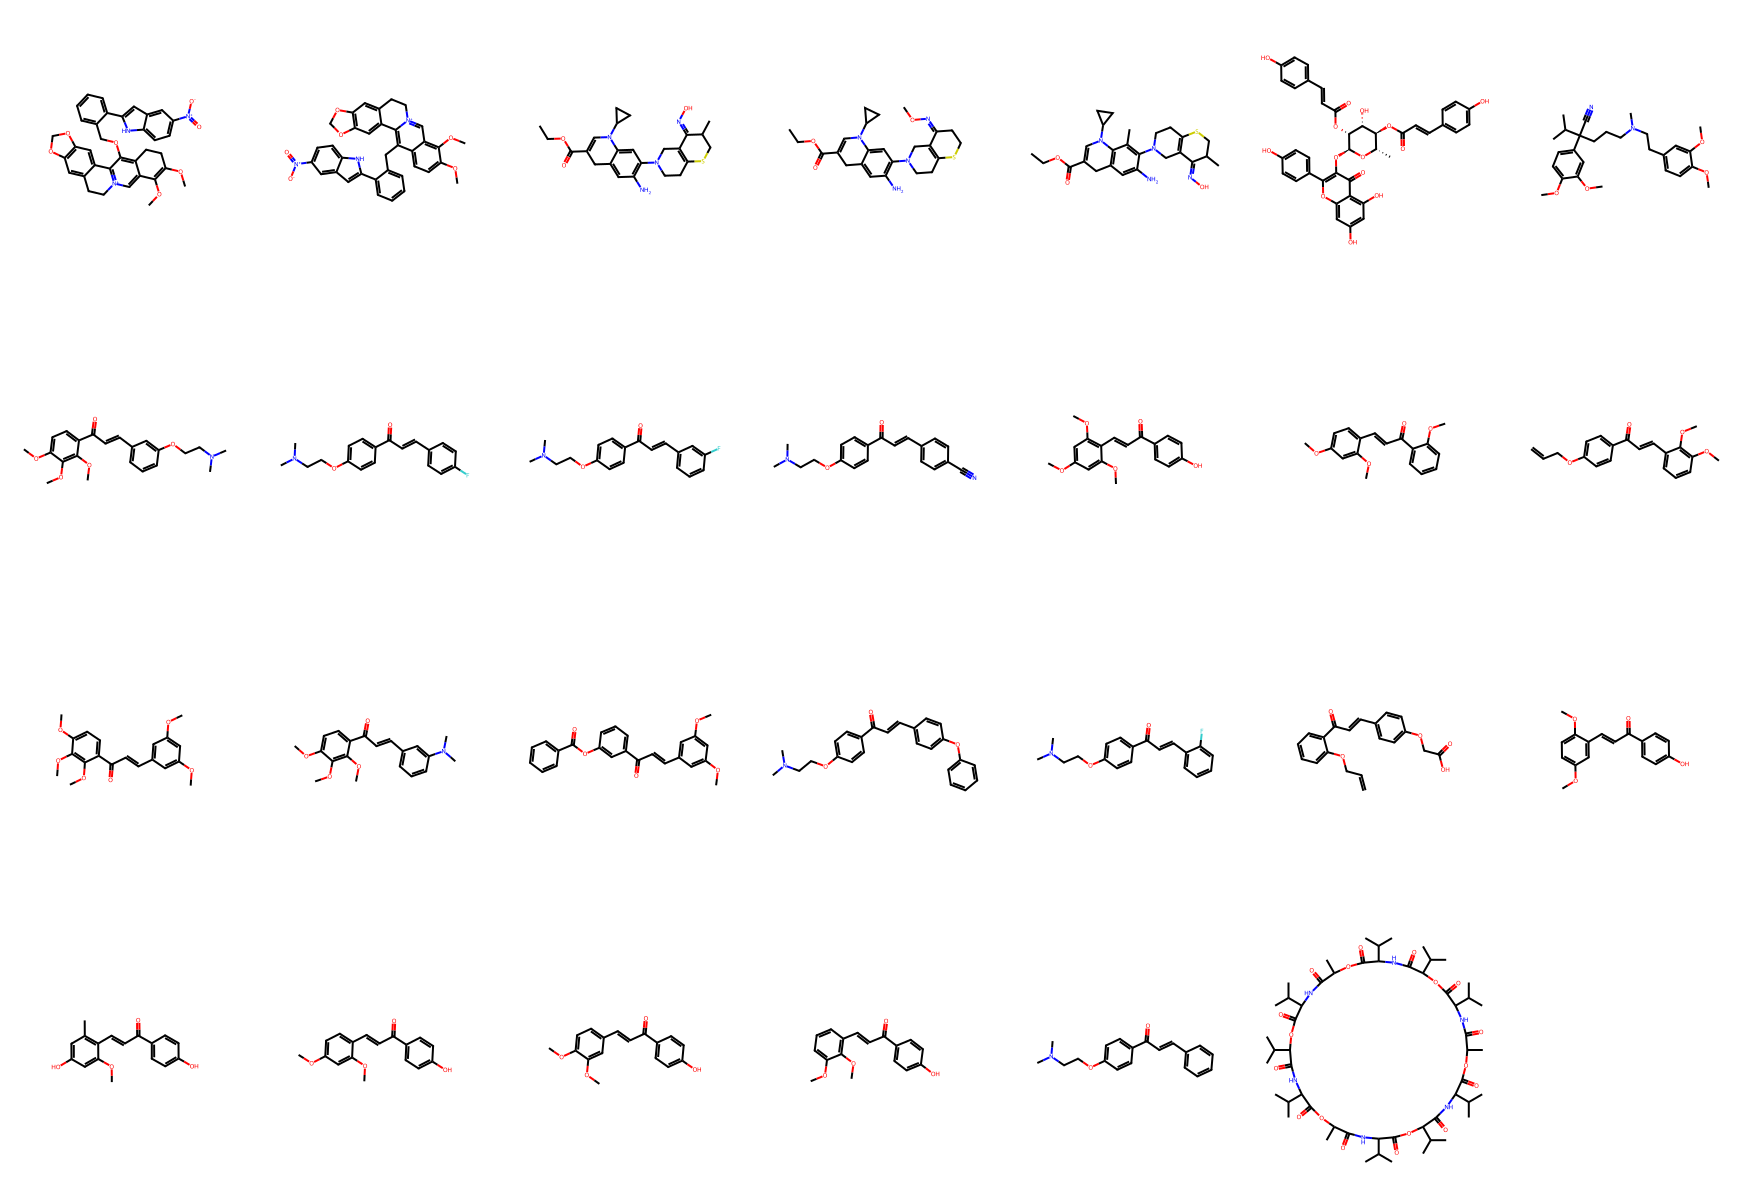

In [1197]:
Draw.MolsToGridImage(mols,  molsPerRow=7, subImgSize=(250,300), drawOptions=opts, useSVG=True)